In [10]:
import yaml
import sys, os
import tqdm
import pandas as pd
import pickle

from IPython.display import Image, SVG

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from src.utils import *
from src.svg_quality_checks import *
from src.gpt_wrappers import *
from src.langchain_database import *

# show svg 
def show_svg(file):
    display(SVG(file))

# load yaml config
with open("../config.yml", "r") as f:
    config = yaml.safe_load(f)

In [4]:
import openai
import wandb

openai.api_key = config["OPENAI_KEY"]
os.environ["OPENAI_API_KEY"] = config["OPENAI_KEY"]

# run = wandb.init(
#     project=config['WANDB_PROJECT'], 
#     entity=config['WANDB_ENTITY']
# )

# results_table = wandb.Table(
#     columns=[
#                 "system_prompt", 
#                 "question_prompt",
#                 "input_svg",
#                 "output_svg",
#                 "input_svg_code",
#                 "output_svg_code",
#                 "valid_check",
#                 "size_check"
#     ]
# )

In [5]:
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAIChat, OpenAI
from langchain.chains.qa_with_sources import load_qa_with_sources_chain

## Create OpenAI index
download the data in separate folders in the "training_data_raw folder"

i.e. "training_data_raw/Footer" ...

In [11]:
# sources = create_sources_from_files(path = "../training_data_raw/", 
#                                     description = "",
#                                     )

# res = []
# llm = OpenAIChat(temperature=0.1, model_name="gpt-3.5-turbo")
# for i, source in tqdm.tqdm(enumerate(sources)):
#     prompt = f"""
#         {sources[i].page_content}.
#         Can you tell me shortly 10+ facts about it? 
#         Talk about: size, colors, shapes, elements, strokes, and text.
#         Give me only keywords, comma-separated. 
#     """
#     try:
#         enriched_description = llm(prompt)
#     except:
#         enriched_description = ""
#     sources[i].page_content = enriched_description + sources[i].page_content
#     res.append({"source": sources[i].metadata["source"], "enriched_description": enriched_description})
#     pd.DataFrame(res).to_csv("enriched_descriptions.csv", index=False)

# save sources as pickle
# with open("sources.pkl", "wb") as f:
#     pickle.dump(sources, f)

# chunks = create_chunks_from_the_sources(sources, 
#                                         separators = [], 
#                                         chunk_size = 1024, 
#                                         chunk_overlap = 0
#                                         )
# index = create_index_from_the_chunks(chunks)
# # save index as pickle
# with open("../resources/index.pkl", "wb") as f:
#     pickle.dump(index, f)


In [37]:
#load sources from pickle
with open("../resources/sources.pkl", "rb") as f:
    sources = pickle.load(f)

# load index from pickle
with open("../resources/index.pkl", "rb") as f:
    index = pickle.load(f)

# Running experiments

## Case 1: no SVG input

In [31]:
system_prompt = \
"""
    You are an expert in design in different fields, you use different vector graphics tools.
    You deal professionally with SVG files, you know how to create complex design with them.
    Your main jon is to complete design systems and tokens based on the initial inputs. 
    These initial inputs are SVG files that can consist of multiple layers, groups, paths, etc.
    They can be different elements as icons, logos, buttons, checkboxes, etc. \n
"""

question_prompt = \
"""=========
TASK:
Generate SVG of {question}.
Keep it as short and optimized as you can, be limited by the tokens.
Start with <svg ... and end with </svg>.
=========
SOURCES:
{summaries}
=========
SVG:"""

template = system_prompt + question_prompt

prompt = PromptTemplate(template=template, input_variables=["summaries", "question"])
chain = load_qa_with_sources_chain(OpenAIChat(temperature=0.1, model_name="gpt-3.5-turbo"), prompt=prompt)
# chain = load_qa_with_sources_chain(OpenAI(temperature=0.9, model_name="text-davinci-003", max_tokens=-1), prompt=prompt)

question = "Footer with segmented buttons saying Email, Post, Horse with corresponding emojis"

answer = chain(
            {
                "input_documents": index.similarity_search(question, k=4),
                "question": question,
            },
            return_only_outputs=True,
        )["output_text"]

print(answer)
print("Quality check:", validate_svg(answer), get_svg_size(answer))

<svg viewBox="0 0 300 50">
  <rect x="0" y="0" width="100" height="50" fill="#32100fdb" rx="10" />
  <text x="25" y="30" fill="#ebedef" font-size="20">Email</text>
  <rect x="100" y="0" width="100" height="50" fill="#32100fdb" rx="10" />
  <text x="125" y="30" fill="#ebedef" font-size="20">Post</text>
  <rect x="200" y="0" width="100" height="50" fill="#32100fdb" rx="10" />
  <text x="225" y="30" fill="#ebedef" font-size="20">Horse</text>
  <text x="50" y="45" font-size="30">&#x1F4E7;</text>
  <text x="150" y="45" font-size="30">&#x1F4E9;</text>
  <text x="250" y="45" font-size="30">&#x1F40E;</text>
</svg>
Quality check: True (-1.0, -1.0)


In [32]:
index.similarity_search(question, k=4)

[Document(page_content='Text: none Icon_Button_Tonal: <svg viewBox="0.00,0.00,48.00,48.00"><g><g><rect rx="20.00" x="4.00" y="4.00" width="40.00" height="40.00" fill="#e8.00def8.00" /></g><g><g><path', metadata={'source': '../training_data_raw/components_material_design/Icon_Button_Tonal.svg', 'name': 'Icon_Button_Tonal', 'style': 'components_material_design'}),
 Document(page_content='Size: 156x42, \nColors: #32100fdb, #ebedef, \nShapes: rectangle with rounded corners, \nElements: text, \nStrokes: none, \nText: "Text Button",', metadata={'source': '../training_data_raw/components_core/Default_Button-1.svg', 'name': 'Default_Button-1', 'style': 'components_core'}),
 Document(page_content='Size: 156x42, \nColors: #32100fdb, #ebedef, \nShapes: rectangle, \nElements: filter, \nStrokes: rounded corners, \nText: "Text Button",', metadata={'source': '../training_data_raw/components_core/Default_Button.svg', 'name': 'Default_Button', 'style': 'components_core'}),
 Document(page_content='Size:


test_optimized.svg:
Done in 12 ms!
0.584 KiB - 9.2% = 0.53 KiB


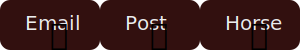

In [33]:
FILENAME = 'test'
save_gpt_answer_as_svg(answer, FILENAME)
show_svg(f'../generated_data/{FILENAME}_optimized.svg')

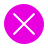

In [39]:
show_svg(f'../generated_data/answer4_optimized.svg')

In [69]:
# results_table.add_data(
#     *[
#         system_prompt, question, 
#         wandb.Html(f'../generated_data/{FILENAME}_optimized.svg'), wandb.Html(f'../generated_data/{FILENAME}_optimized.svg'),
#         "", answer,
#         validate_svg(answer), get_svg_size(answer)
#     ]
# )

## Case 2: SVG input


segmented_buttons_short_optimized.svg:
Done in 60 ms!
13.162 KiB - 70.3% = 3.909 KiB


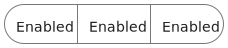

In [18]:
FILENAME = "segmented_buttons_short"
svg_original = load_raw_svg_optimize_clean(FILENAME)
show_svg(f'../data/svgs/{FILENAME}_optimized.svg')

In [19]:
system_prompt = \
"""
    You are an expert in design in different fields, you use different vector graphics tools.
    You deal professionally with SVG files, you know how to create complex design with them.
    Your main jon is to complete design systems and tokens based on the initial inputs. 
    These initial inputs are SVG files that can consist of multiple layers, groups, paths, etc.
    They can be different elements as icons, logos, buttons, checkboxes, etc. \n
"""

question_prompt = \
"""=========
TASK:
Generate SVG of {question}.
Keep it as short and optimized as you can, be limited by the tokens.
Start with <svg ... and end with </svg>.
=========
SIMILAR ELEMENTS:
{summaries}
=========
SVG:"""

template = system_prompt + question_prompt

prompt = PromptTemplate(template=template, input_variables=["summaries", "question"])
chain = load_qa_with_sources_chain(OpenAIChat(temperature=0.9, model_name="gpt-3.5-turbo"), prompt=prompt)

question = f"Segmented buttons the same as in the following SVG but middle button is green {svg_original}"

answer = chain(
            {
                "input_documents": index.similarity_search(question, k=2),
                "question": question,
            },
            return_only_outputs=True,
        )["output_text"]

print(answer)
print("Quality check:", validate_svg(answer), get_svg_size(answer))

<svg fill="none" viewBox="0.00 0.00 228.00 48.00">
  <style></style>
  <defs>
    <clipPath id="s1.00">
      <rect width="228.00" height="48.00" rx="0.00" ry="0.00"/>
    </clipPath>
    <clipPath id="s2.00">
      <rect width="220.00" height="40.00" x="4.00" y="4.00" rx="0.00" ry="0.00"/>
    </clipPath>
    <clipPath id="s3.00">
      <path d="M150.00,4.00h54.00a20.00,20.00,0.00,0.00,1.00,20.00,20.00,20.00,20.00,0.00,0.00,1.00-20.00,20.00h-54.00V4.00z"/>
    </clipPath>
    <path id="s5.00" d="M150.00,4.00h54.00a20.00,20.00,0.00,0.00,1.00,20.00,20.00,20.00,20.00,0.00,0.00,1.00-20.00,20.00h-54.00V4.00z" fill="#1e92b" stroke-width="2.00" stroke="#79747.00e"/>
    <clipPath id="s6.00">
      <rect width="74.00" height="40.00" x="77.00" y="4.00" rx="0.00" ry="0.00"/>
    </clipPath>
    <rect id="s8.00" width="74.00" height="40.00" x="77.00" y="4.00" rx="0.00" ry="0.00" fill="#1e92b" stroke-width="2.00" stroke="#79747.00e"/>
    <clipPath id="s9.00">
      <path d="M24.00,4.00h54.00v40.

In [20]:
save_gpt_answer_as_svg(answer, FILENAME)
show_svg(f'../generated_data/{FILENAME}_optimized.svg')

ParseError: unclosed token: line 30, column 2 (<string>)

In [ ]:
# results_table.add_data(
#     *[
#         system_prompt, question, 
#         wandb.Html(f'../data/svgs/{FILENAME}_optimized.svg'), wandb.Html(f'../generated_data/{FILENAME}_optimized.svg'),
#         svg_original, answer,
#         validate_svg(answer), get_svg_size(answer)
#     ]
# )

## Log everything

In [ ]:
# run.log({"results_table": results_table})